In [77]:
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps
import PIL
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from dataset import defectDataset_df, create_circular_mask, split_and_sample
import random
import math
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import time
import os
from grayscale_resnet import resnet18
from torchvision.models.resnet import BasicBlock, conv3x3, Bottleneck

In [78]:
window_size = 80
pad_size = window_size
classes = ["pos","neg","pos_o","nuc","non"]
batch_size = 8

In [79]:
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(200, scale=(1, 1), ratio=(1, 1)),
        transforms.RandomRotation((-90,90)),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0, hue=0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3019],
                             std=[0.1909])
    ])

In [80]:
trainset = defectDataset_df(df = split_and_sample(method = 'hard',n_samples = 1995), window_size = window_size, transforms=data_transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=4)
print("trainloader ready!")

testset = defectDataset_df(df = split_and_sample(df_train = pd.read_csv('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/test.csv', sep=" "),
                                                      method = 'hard',n_samples = 500), window_size = window_size, transforms=data_transform)
testloader = torch.utils.data.DataLoader(testset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=4)
print("testloader ready!")

trainloader ready!
testloader ready!


In [81]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU in use")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classes = ["pos","neg","pos_o","nuc","non"]
num_of_classes = len(classes)

GPU in use


In [82]:
def imshow(img):
    img = img * 0.1909 + 0.3019     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

GroundTruth:    pos   neg   neg   nuc   pos   non   non   pos
tensor([0, 1, 1, 3, 0, 4, 4, 0])


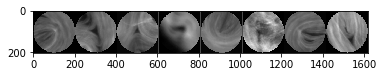

In [91]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
classes = ["pos","neg","pos_o","nuc","non"]
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))
print(labels)

In [86]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training phase
        scheduler.step()
        model.train(True)  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for data in trainloader:
            # get the inputs
            inputs, labels = data
#            print(inputs)
            # wrap them in Variable
            if use_gpu:
#                inputs = Variable(inputs.cuda())
#                labels = Variable(labels.cuda())
#                inputs = torch.nn.DataParallel(inputs, device_ids=[0, 1]).cuda()
#                labels = torch.nn.DataParallel(labels, device_ids=[0, 1]).cuda()
                inputs, labels = inputs.to(device), labels.to(device)
#                print(inputs)
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()


            m = nn.LogSoftmax(dim=0)
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(m(outputs), labels)
            # forward
#            outputs = model(inputs)
#            _, preds = torch.max(outputs.data, 1)
#            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # statistics
            iter_loss = loss.item()
            correct = torch.sum(preds == labels.data).item()
            batch_accuracy = correct / batch_size
            running_loss += loss.item()
            running_corrects_tensor = torch.sum(preds == labels.data)
            running_corrects += running_corrects_tensor.item()        
            epoch_loss = running_loss / len(trainset)
            epoch_acc = running_corrects / len(trainset)
            
            print('{} Loss: {:.4f} Acc: {:.4f} batch_loss: {:.4f} correct: {:d} batch_accuracy: {:.4f}'.format(
                "train", epoch_loss, epoch_acc, iter_loss, correct, batch_accuracy))
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
#                print('processed: %d' % total)
#                print('correct: %d' % correct)
        print('Accuracy of the network on the test images: %.5f %%' % (
            100 * correct / total))
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:

# transfer learning resnet18
model_ft = resnet18()
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_of_classes)

if use_gpu:
    model_ft = torch.nn.DataParallel(model_ft)
    model_ft.to(device)

criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001,  momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.1)

# train model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)
torch.save(model_ft, output_path)



Epoch 0/4
----------
train Loss: 0.0005 Acc: 0.0027 batch_loss: 4.8634 correct: 27 batch_accuracy: 0.2109
train Loss: 0.0010 Acc: 0.0050 batch_loss: 4.8852 correct: 23 batch_accuracy: 0.1797
train Loss: 0.0015 Acc: 0.0079 batch_loss: 4.8780 correct: 29 batch_accuracy: 0.2266
train Loss: 0.0020 Acc: 0.0100 batch_loss: 4.8742 correct: 21 batch_accuracy: 0.1641
train Loss: 0.0024 Acc: 0.0124 batch_loss: 4.8604 correct: 24 batch_accuracy: 0.1875
train Loss: 0.0029 Acc: 0.0150 batch_loss: 4.8617 correct: 26 batch_accuracy: 0.2031
train Loss: 0.0034 Acc: 0.0171 batch_loss: 4.8577 correct: 21 batch_accuracy: 0.1641
train Loss: 0.0039 Acc: 0.0206 batch_loss: 4.8479 correct: 34 batch_accuracy: 0.2656
train Loss: 0.0044 Acc: 0.0231 batch_loss: 4.8426 correct: 25 batch_accuracy: 0.1953
train Loss: 0.0049 Acc: 0.0258 batch_loss: 4.8424 correct: 27 batch_accuracy: 0.2109
train Loss: 0.0054 Acc: 0.0280 batch_loss: 4.8379 correct: 22 batch_accuracy: 0.1719
train Loss: 0.0058 Acc: 0.0302 batch_loss: 4

train Loss: 0.0089 Acc: 0.0745 batch_loss: 4.6981 correct: 35 batch_accuracy: 0.2734
train Loss: 0.0093 Acc: 0.0784 batch_loss: 4.6035 correct: 39 batch_accuracy: 0.3047
train Loss: 0.0098 Acc: 0.0823 batch_loss: 4.6713 correct: 39 batch_accuracy: 0.3047
train Loss: 0.0103 Acc: 0.0874 batch_loss: 4.6354 correct: 51 batch_accuracy: 0.3984
train Loss: 0.0107 Acc: 0.0912 batch_loss: 4.6541 correct: 38 batch_accuracy: 0.2969
train Loss: 0.0112 Acc: 0.0957 batch_loss: 4.5937 correct: 45 batch_accuracy: 0.3516
train Loss: 0.0117 Acc: 0.1007 batch_loss: 4.6372 correct: 49 batch_accuracy: 0.3828
train Loss: 0.0121 Acc: 0.1055 batch_loss: 4.6129 correct: 48 batch_accuracy: 0.3750
train Loss: 0.0126 Acc: 0.1098 batch_loss: 4.6108 correct: 43 batch_accuracy: 0.3359
train Loss: 0.0130 Acc: 0.1141 batch_loss: 4.6259 correct: 43 batch_accuracy: 0.3359
train Loss: 0.0135 Acc: 0.1181 batch_loss: 4.6398 correct: 40 batch_accuracy: 0.3125
train Loss: 0.0140 Acc: 0.1228 batch_loss: 4.6373 correct: 47 bat

train Loss: 0.0171 Acc: 0.1702 batch_loss: 4.5974 correct: 53 batch_accuracy: 0.4141
train Loss: 0.0176 Acc: 0.1741 batch_loss: 4.6754 correct: 39 batch_accuracy: 0.3047
train Loss: 0.0181 Acc: 0.1794 batch_loss: 4.5876 correct: 53 batch_accuracy: 0.4141
train Loss: 0.0185 Acc: 0.1842 batch_loss: 4.6015 correct: 47 batch_accuracy: 0.3672
train Loss: 0.0190 Acc: 0.1894 batch_loss: 4.6142 correct: 52 batch_accuracy: 0.4062
train Loss: 0.0195 Acc: 0.1942 batch_loss: 4.5625 correct: 48 batch_accuracy: 0.3750
train Loss: 0.0199 Acc: 0.1987 batch_loss: 4.6344 correct: 45 batch_accuracy: 0.3516
train Loss: 0.0204 Acc: 0.2033 batch_loss: 4.6556 correct: 46 batch_accuracy: 0.3594
train Loss: 0.0208 Acc: 0.2084 batch_loss: 4.6270 correct: 51 batch_accuracy: 0.3984
train Loss: 0.0213 Acc: 0.2131 batch_loss: 4.6501 correct: 47 batch_accuracy: 0.3672
train Loss: 0.0218 Acc: 0.2175 batch_loss: 4.6170 correct: 44 batch_accuracy: 0.3438
train Loss: 0.0222 Acc: 0.2225 batch_loss: 4.6275 correct: 49 bat

KeyboardInterrupt: 